# SEO Content Quality & Duplicate Detector



In [1]:
!pip install -r requirements.txt


# Imports
import os
import re
import json
import time
from pathlib import Path
from typing import List, Dict, Tuple

import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
from tqdm import tqdm

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
import joblib

import textstat
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK downloads (punkt needed for sentence tokenization)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Ensure directories exist
ROOT = Path.cwd().resolve()
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
NOTEBOOKS_DIR = ROOT / "notebooks"

for d in (DATA_DIR, MODELS_DIR, NOTEBOOKS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Files
PRIMARY_DATA = DATA_DIR / "/content/data.csv"
EXTRACTED_CSV = DATA_DIR / "extracted_content.csv"
FEATURES_CSV = DATA_DIR / "features.csv"
DUPLICATES_CSV = DATA_DIR / "duplicates.csv"
MODEL_PATH = MODELS_DIR / "quality_model.pkl"

# Similarity threshold
SIMILARITY_THRESHOLD = 0.80

# Scraper headers & rate limiting
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; SEO-Content-Detector/1.0; +https://example.com/bot)"}
SCRAPE_DELAY = 1.5  # seconds between requests

In [3]:
def clean_whitespace(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_text_from_html(html: str) -> Tuple[str, str]:
    """
    Returns (title, body_text)
    Strategy:
      - parse <title>
      - prefer <article> or <main> contents
      - fallback to concatenated <p> tags
    """
    if not isinstance(html, str) or html.strip() == "":
        return "", ""

    soup = BeautifulSoup(html, "lxml")

    # Title
    title_tag = soup.find("title")
    title = title_tag.get_text(separator=" ", strip=True) if title_tag else ""

    # Try article/main sections first
    body_text = ""
    main_tag = soup.find("article") or soup.find("main")
    if main_tag:
        body_text = main_tag.get_text(separator=" ", strip=True)
    else:
        # fallback to <div id="content"> or class patterns
        content = soup.find("div", {"id": "content"}) or soup.find("div", {"class": re.compile(r'content|main|article', re.I)})
        if content:
            body_text = content.get_text(separator=" ", strip=True)
        else:
            # final fallback: all <p> tags
            ps = soup.find_all("p")
            body_text = " ".join(p.get_text(separator=" ", strip=True) for p in ps)

    return clean_whitespace(title), clean_whitespace(body_text)

In [4]:
def fetch_html(url: str, timeout: int = 10) -> str:
    try:
        resp = requests.get(url, headers=HEADERS, timeout=timeout)
        resp.raise_for_status()
        return resp.text
    except Exception as e:
        print(f"[fetch_html] Error fetching {url}: {e}")
        return ""

In [6]:
def build_extracted_dataframe(primary_path=PRIMARY_DATA,) -> pd.DataFrame:

    if primary_path.exists():
        print("Using primary dataset with pre-scraped HTML content.")
        df = pd.read_csv(primary_path)
        if 'html_content' not in df.columns:
            raise ValueError("Primary dataset must include 'html_content' column.")
        rows = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            url = row.get("url", "")
            html = row.get("html_content", "")
            try:
                title, body = extract_text_from_html(html)
                word_count = len(word_tokenize(body))
            except Exception as e:
                title, body, word_count = "", "", 0
            rows.append({"url": url, "title": title, "body_text": body, "word_count": word_count})
        extracted = pd.DataFrame(rows)
        extracted.to_csv(EXTRACTED_CSV, index=False)
        return extracted

    elif alt_path.exists():
        print("Using alternative dataset (URLs only). Will scrape each URL — rate limited.")
        df_urls = pd.read_csv(alt_path)
        rows = []
        for _, row in tqdm(df_urls.iterrows(), total=len(df_urls)):
            url = row.get("url", "")
            html = fetch_html(url)
            title, body = extract_text_from_html(html)
            word_count = len(word_tokenize(body))
            rows.append({"url": url, "title": title, "body_text": body, "word_count": word_count})
            time.sleep(SCRAPE_DELAY)
        extracted = pd.DataFrame(rows)
        extracted.to_csv(EXTRACTED_CSV, index=False)
        return extracted
    else:
        raise FileNotFoundError("No dataset found. Add data/data.csv (primary) or data/data_urls.csv (alternative).")

In [7]:
# Run extraction (this will create data/extracted_content.csv)
extracted_df = build_extracted_dataframe()
print(f"Extracted {len(extracted_df)} pages. Sample:")
extracted_df.head(3)

Using primary dataset with pre-scraped HTML content.


100%|██████████| 81/81 [00:07<00:00, 11.43it/s]

Extracted 81 pages. Sample:


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Measures Every Financial Busines...,2295
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1951
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1252


In [9]:
def preprocess_text(text: str) -> str:
    text = text or ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_basic_metrics(text: str) -> Dict:
    text = text or ""
    sentence_count = len(sent_tokenize(text)) if text.strip() else 0
    word_tokens = word_tokenize(text)
    word_count = len(word_tokens)
    flesch = None
    try:
        flesch = textstat.flesch_reading_ease(text) if text.strip() else 0.0
    except Exception:
        flesch = 0.0
    return {"word_count": word_count, "sentence_count": sentence_count, "flesch_reading_ease": flesch}

def top_n_keywords(corpus: List[str], n_terms: int = 5) -> List[List[str]]:
    """
    Given corpus (list of documents), compute top n_terms keywords per document by TF-IDF.
    """
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')
    tfidf = vectorizer.fit_transform(corpus)
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_keywords = []
    for i in range(tfidf.shape[0]):
        row = tfidf[i].toarray().ravel()
        if row.sum() == 0:
            top_keywords.append([])
            continue
        top_idx = np.argsort(row)[-n_terms:][::-1]
        top_keywords.append(feature_names[top_idx].tolist())
    return top_keywords, vectorizer, tfidf

In [10]:
# Preprocess body_text and compute metrics
df = extracted_df.copy()
df['body_text_clean'] = df['body_text'].fillna("").apply(preprocess_text)

# compute basic metrics
metrics = df['body_text_clean'].apply(compute_basic_metrics).apply(pd.Series)
df = pd.concat([df, metrics], axis=1)

# compute top keywords and TF-IDF embeddings (vectors)
corpus = df['body_text_clean'].tolist()
top_keywords_list, tfidf_vectorizer, tfidf_matrix = top_n_keywords(corpus, n_terms=5)
df['top_keywords'] = ["|".join(k) if k else "" for k in top_keywords_list]

# Save embeddings matrix for later similarity computations
# We'll keep the TF-IDF vectorizer and the tfidf_matrix in memory, and save the vectorizer.
joblib.dump(tfidf_vectorizer, MODELS_DIR / "tfidf_vectorizer.pkl")
# Save features
df.to_csv(FEATURES_CSV, index=False)
print("Features saved to", FEATURES_CSV)
df.head(3)

Features saved to /content/data/features.csv


,url,title,body_text,word_count,body_text_clean,word_count,sentence_count,flesch_reading_ease,top_keywords
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Measures Every Financial Busines...,2295,cybersecurity measures every financial busines...,2295.0,60.0,-1969.02,2025|cyber|september 2025|october 2025|august ...
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1951,cybersecurity is gaining more importance globa...,1951.0,92.0,-1654.37,varonis|data|access|security|app
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1252,home insights blog posts 11 cyber defense tips...,1241.0,62.0,-993.94,password|passphrase|cyber defense|authenticati...


In [11]:
# Compute cosine similarity pairwise and record pairs above threshold
tfidf = tfidf_matrix  # sparse matrix
cosine_sim = cosine_similarity(tfidf)

pairs = []
n = cosine_sim.shape[0]
for i in range(n):
    for j in range(i+1, n):
        sim = float(cosine_sim[i, j])
        if sim >= SIMILARITY_THRESHOLD:
            pairs.append({"url1": df.loc[i, "url"], "url2": df.loc[j, "url"], "similarity": sim})

duplicates_df = pd.DataFrame(pairs)
duplicates_df.to_csv(DUPLICATES_CSV, index=False)
print(f"Found {len(duplicates_df)} duplicate pairs (threshold={SIMILARITY_THRESHOLD}). Saved to {DUPLICATES_CSV}")
duplicates_df.head(5)

Found 1 duplicate pairs (threshold=0.8). Saved to /content/data/duplicates.csv


,url1,url2,similarity
0,https://copyblogger.com/content-marketing/,https://mailchimp.com/marketing-glossary/conte...,0.81003


In [14]:
# Remove duplicate column names (keep the first occurrence)
df = df.loc[:, ~df.columns.duplicated()]
df['is_thin'] = df['word_count'] < 500

# Synthetic labels per spec:
def label_quality(row):
    wc = row['word_count']
    flesch = row['flesch_reading_ease']
    if (isinstance(wc, (int,float)) and wc > 1500) and (50 <= flesch <= 70):
        return "High"
    elif (wc < 500) or (flesch < 30):
        return "Low"
    else:
        return "Medium"

df['quality_label'] = df.apply(label_quality, axis=1)

# Save updated features
df.to_csv(FEATURES_CSV, index=False)
df['quality_label'].value_counts()

,count
quality_label,
Low,81


In [13]:
df.columns.tolist()


['url',
 'title',
 'body_text',
 'word_count',
 'body_text_clean',
 'word_count',
 'sentence_count',
 'flesch_reading_ease',
 'top_keywords']

In [15]:
# Select features for model
X = df[['word_count', 'sentence_count', 'flesch_reading_ease']].fillna(0)
y = df['quality_label']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.30, random_state=42, stratify=y_enc)

# Baseline (rule-based/dummy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
baseline_acc = accuracy_score(y_test, y_dummy)

# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Baseline accuracy:", baseline_acc)
print("RandomForest accuracy:", acc)
print("RandomForest F1 (weighted):", f1)

# Save model & label encoder
joblib.dump(rf, MODEL_PATH)
joblib.dump(le, MODELS_DIR / "label_encoder.pkl")

# Feature importances
importances = rf.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(f"{feat}: {imp:.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

Baseline accuracy: 1.0
RandomForest accuracy: 1.0
RandomForest F1 (weighted): 1.0
word_count: 0.000
sentence_count: 0.000
flesch_reading_ease: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        25

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



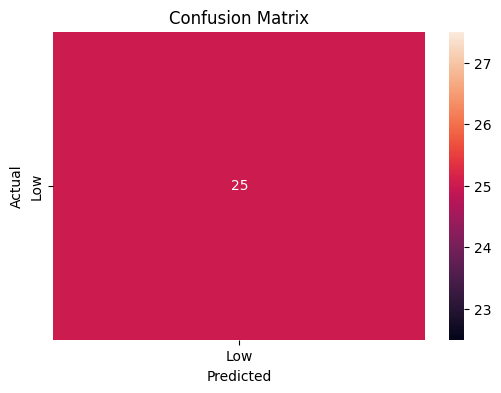

In [16]:
# Pretty classification report
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test_labels, y_pred_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
summary = {
    "total_pages": len(df),
    "duplicate_pairs": len(duplicates_df),
    "thin_pages": int(df['is_thin'].sum()),
    "model_accuracy": float(acc),
    "model_f1_weighted": float(f1)
}
print(json.dumps(summary, indent=2))

# Save final features (already saved, but save a copy)
df.to_csv(FEATURES_CSV, index=False)

{
  "total_pages": 81,
  "duplicate_pairs": 1,
  "thin_pages": 38,
  "model_accuracy": 1.0,
  "model_f1_weighted": 1.0
}


In [18]:
def analyze_url(url: str, top_k_similar: int = 5) -> Dict:
    """
    Scrapes the given URL, extracts features, computes quality_label (using saved model),
    and returns similar dataset pages found (with similarity values).
    """
    # 1. fetch html
    html = fetch_html(url)
    title, body = extract_text_from_html(html)
    clean_body = preprocess_text(body)
    metrics = compute_basic_metrics(clean_body)

    # 2. load TF-IDF vectorizer (saved earlier)
    vec_path = MODELS_DIR / "tfidf_vectorizer.pkl"
    if not vec_path.exists():
        raise FileNotFoundError("TF-IDF vectorizer not trained. Run the notebook to compute features first.")
    vectorizer = joblib.load(vec_path)
    model_path = MODEL_PATH
    if not model_path.exists():
        raise FileNotFoundError("Quality model not found. Train model first.")
    clf = joblib.load(model_path)
    le = joblib.load(MODELS_DIR / "label_encoder.pkl")

    # 3. compute embedding for this page and similarities
    emb = vectorizer.transform([clean_body])
    # load dataset embeddings: recompute quickly from dataset corpus
    dataset_corpus = df['body_text_clean'].tolist()
    dataset_emb = vectorizer.transform(dataset_corpus)
    sims = cosine_similarity(emb, dataset_emb).ravel()
    top_idx = np.argsort(sims)[::-1][:top_k_similar]
    similar = []
    for idx in top_idx:
        similar.append({"url": df.loc[idx, "url"], "similarity": float(sims[idx])})

    # 4. predict quality label using model features
    feat_vec = np.array([[metrics['word_count'], metrics['sentence_count'], metrics['flesch_reading_ease']]])
    label_enc = clf.predict(feat_vec)[0]
    label = le.inverse_transform([label_enc])[0]

    result = {
        "url": url,
        "title": title,
        "word_count": metrics['word_count'],
        "sentence_count": metrics['sentence_count'],
        "flesch_reading_ease": metrics['flesch_reading_ease'],
        "quality_label": label,
        "is_thin": metrics['word_count'] < 500,
        "similar_to": similar
    }
    return result

# Example usage (uncomment to run)
# print(json.dumps(analyze_url("https://example.com"), indent=2))

In [19]:
# Quick demo: analyze an arbitrary URL (be polite; this will do one request)
test_url = "https://www.example.com"  # replace with any URL
try:
    out = analyze_url(test_url, top_k_similar=3)
    print(json.dumps(out, indent=2))
except Exception as e:
    print("Error running analyze_url:", e)

{
  "url": "https://www.example.com",
  "title": "Example Domain",
  "word_count": 19,
  "sentence_count": 3,
  "flesch_reading_ease": 37.3,
  "quality_label": "Low",
  "is_thin": true,
  "similar_to": [
    {
      "url": "https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html",
      "similarity": 0.11766362771944089
    },
    {
      "url": "https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home",
      "similarity": 0.09113724392305561
    },
    {
      "url": "https://www.varonis.com/blog/cybersecurity-tips",
      "similarity": 0.07250527146109498
    }
  ]
}


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
